# Classificazione di corpi celesti

**Programmazione di Applicazioni Data Intensive**

Laurea in Ingegneria e Scienze Informatiche

DISI - Università di Bologna, Cesena


**Studente**: Luca Marchi

**Matricola**: 0001070850


## 1. Analisi e descrizione del problema

### Scopo del progetto

Lo scopo di questo progetto è realizzare un modello che possa classificare i corpi celesti in base alle loro caratteristiche spettrali, utilizzando tecniche di machine learning per identificare le classi di oggetti celesti presenti nel dataset.

### Dataset

Si è preso come riferimento [questo](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) dataset trovato sulla piattaforma [Kaggle](https://www.kaggle.com/). 

Il dataset contiene le caratteristiche spettrali dei corpi celesti.

Le caratteristiche spettrali sono linee o bande di assorbimento o emissione che compaiono nello spettro elettromagnetico (la "scomposizione" della luce). Sono come un codice a barre o un'impronta digitale unica che ci permette di decifrare la composizione chimica, la temperatura, la densità, la velocità e molte altre proprietà fisiche di stelle, galassie, pianeti e nebulose senza doverci recare fisicamente da loro.

I dati consistono in 100.000 osservazioni dello spazio raccolte dallo SDSS (Sloan Digital Sky Survey).
Ogni osservazione è descritta da 17 colonne di feature e 1 colonna di classe, che la identifica come stella, galassia o quasar.

### Librerie utilizzate

In [524]:

import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Caricamento dei dati 

In [488]:
FILE_NAME = "star_classification.csv"

In [489]:

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")

print("Path to dataset files:", path)


Path to dataset files: /Users/lucamarchi/.cache/kagglehub/datasets/fedesoriano/stellar-classification-dataset-sdss17/versions/1


In [490]:
df = pd.read_csv(f"{path}/{FILE_NAME}")

Osserviamo le prime righe del dataset per comprendere meglio la sua struttura e il tipo di informazioni contenute.

In [491]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Otteniamo informazioni più dettagliate sull'uso della memoria, inclusi i tipi di dati e il numero di istanze non nulle.

In [492]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Notiamo che nel dataset non sono presenti valori nulli, quindi possiamo procedere con le fasi successive senza doverci preoccupare di gestire dati mancanti.

### Significato delle colonne


Riporto di seguito il significato delle colonne del dataset come specificato dalla [fonte](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17):

- **obj_ID**: Identificatore dell’oggetto, il valore univoco che identifica l’oggetto nel catalogo di immagini usato dal CAS (Catalog Archive Server)

- **alpha**: Angolo di Ascensione Retta (all’epoca J2000)

- **delta**: Angolo di Declinazione (all’epoca J2000)

- **u**: Filtro ultravioletto nel sistema fotometrico

- **g**: Filtro verde nel sistema fotometrico

- **r**: Filtro rosso nel sistema fotometrico

- **i**: Filtro nel vicino infrarosso nel sistema fotometrico

- **z**: Filtro infrarosso nel sistema fotometrico

- **run_ID**: Numero di “run” usato per identificare la specifica scansione

- **rerun_ID**: Numero di “rerun” per specificare come è stata processata l’immagine

- **cam_col**: Colonna della camera che identifica la scanline all’interno del run

- **field_ID**: Numero di campo per identificare ciascun campo

- **spec_obj_ID**: ID univoco usato per oggetti spettroscopici ottici (questo significa che 2 osservazioni diverse con lo stesso spec_obj_ID devono condividere la stessa classe di output)

- **class**: Classe dell’oggetto (galassia, stella o quasar)

- **redshift**: Valore di redshift basato sull’aumento della lunghezza d’onda

- **plate**: ID della lastra, identifica ciascuna lastra nello SDSS

- **MJD**: Data Giuliana Modificata, usata per indicare quando è stato raccolto un determinato dato dello SDSS (sistema di datazione molto usato in astronomia per indicare momenti specifici nel tempo)

- **fiber_ID**: ID della fibra che identifica la fibra ottica che ha raccolto la luce nel piano focale in ciascuna osservazione

Rinominiamo in maniera più chiara le colonne del dataset per facilitare la comprensione e l'analisi dei dati.

In [493]:
df = df.rename(columns={
    "obj_ID": "object_id",
    "alpha": "right_ascension",
    "delta": "declination",
    "u": "ultraviolet_filter",
    "g": "green_filter",
    "r": "red_filter",
    "i": "near_infrared_filter",
    "z": "infrared_filter",
    "run_ID": "run_id",
    "rerun_ID": "rerun_id",
    "cam_col": "camera_column",
    "field_ID": "field_id",
    "spec_obj_ID": "spec_object_id",
    "MJD": "modified_julian_date",
    "fiber_ID": "fiber_id"
})

In [494]:
df.head()

,object_id,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,run_id,rerun_id,camera_column,field_id,spec_object_id,class,redshift,plate,modified_julian_date,fiber_id
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### Visualizzazione della distribuzione delle classi

**Istogramma**

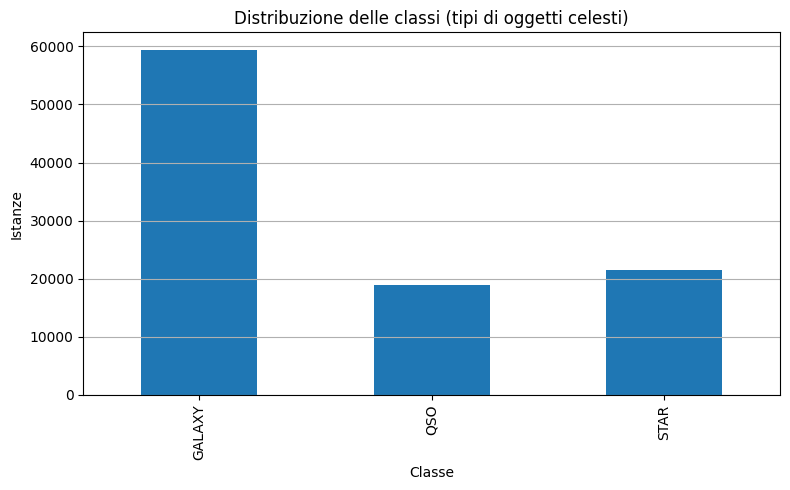

In [495]:
plt.figure(figsize=(8, 5))
df['class'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuzione delle classi (tipi di oggetti celesti)')
plt.xlabel('Classe')
plt.ylabel('Istanze')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Grafico a torta**

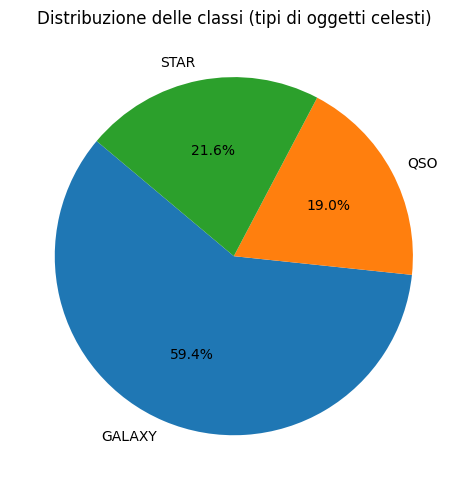

In [496]:
classes = df['class'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
classes.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione delle classi (tipi di oggetti celesti)')
plt.ylabel('')
plt.tight_layout()
plt.show()

Osservando i grafici possiamo notare che le classi non sono bilanciate, con una predominanza di galassie (circa il 60%) rispetto a stelle e quasar (circa il 20% l'uno). 

## 2. Analisi esplorativa

Otteniamo informazioni di base e statistiche sul dataset.

In [497]:
df.describe()

,object_id,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,run_id,rerun_id,camera_column,field_id,spec_object_id,redshift,plate,modified_julian_date,fiber_id
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


### Presenza di duplicati


Controllare la presenza di duplicati basati su **spec_object_id** è fondamentale per garantire l'integrità del dataset. Come citato nella documentazione 2 osservazioni diverse con lo stesso spec_obj_ID devono condividere la stessa classe di output. Pertanto, è importante identificare e gestire eventuali duplicati nel dataset prima di procedere con l'addestramento del modello.

In [498]:
# Verifica duplicati basati su spec_object_id (come menzionato nella documentazione)
print("Duplicati basati su spec_object_id:")
duplicates = df[df.duplicated(subset=['spec_object_id'], keep=False)]
print(f"Numero di righe duplicate: {len(duplicates)}")

# Verifica duplicati completi
print(f"\nDuplicati completi (righe identiche del dataset): {df.duplicated().sum()}")

Duplicati basati su spec_object_id:
Numero di righe duplicate: 0

Duplicati completi (righe identiche del dataset): 0


Come possiamo osservare non ci sono duplicati basati su spec_object_ID e neanche duplicati completi con tutte le colonne identiche.

### Rimozione di colonne non rilevanti per la classificazione

Alcune colonne sono semplicemente ID univoci o informazioni tecniche e non forniscono informazioni utili per la classificazione. Queste colonne possono essere rimosse per semplificare il dataset.

In [499]:
features_to_drop = ["object_id", "spec_object_id", "run_id", "field_id", "plate", "fiber_id"]
df = df.drop(columns=features_to_drop)

La feature **rerun_id** è sempre uguale a 301 quindi posso rimuoverla in quanto non apporta informazioni utili alla classificazione degli oggetti celesti.

In [500]:
df = df.drop(columns=['rerun_id'])

### Analisi degli outliers

Analizziamo gli outliers per le features numeriche principali.

In [501]:
numeric_features = ['ultraviolet_filter', 'green_filter', 'red_filter', 
                   'near_infrared_filter', 'infrared_filter', 'redshift']


In [502]:
def plot_box_diagram(features):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        df.boxplot(column=feature, by='class', ax=axes[i])
        axes[i].set_title(f'{feature} by class')
        
    plt.tight_layout()
    plt.show()

In [503]:
def plot_feature_distribution(features):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, feature in enumerate(features):
        ax = axes[i // 3, i % 3]
        sns.histplot(df[feature], bins=30, kde=True, ax=ax)
        ax.set_title(f'Distribuzione della caratteristica: {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequenza')
        ax.grid()
    plt.tight_layout()
    plt.show()

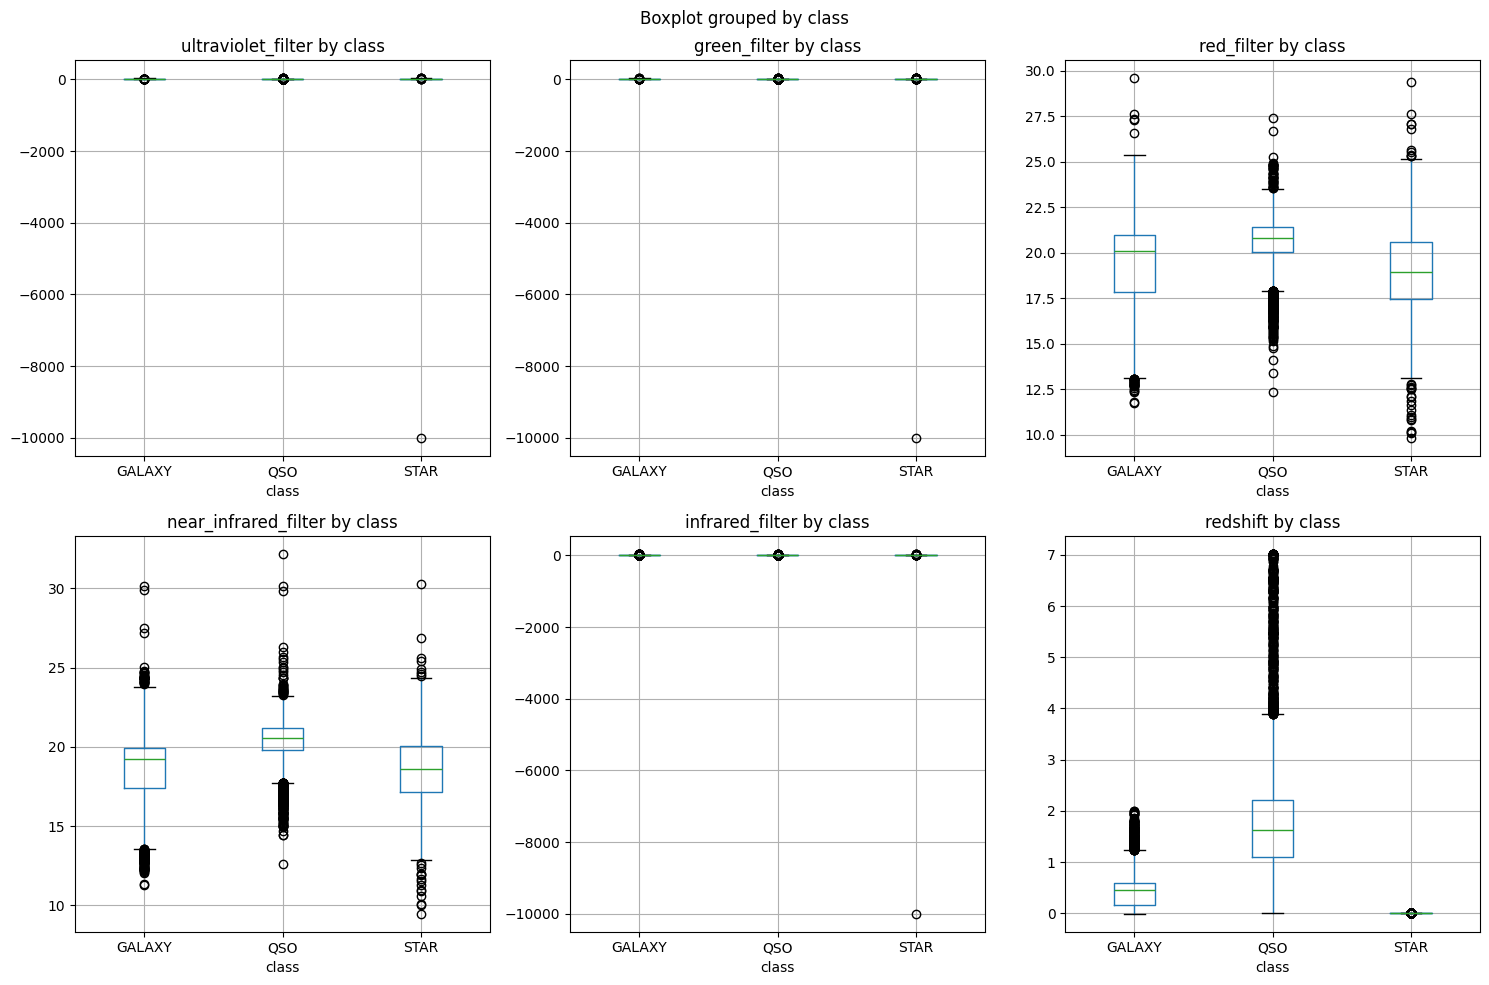

In [504]:
plot_box_diagram(numeric_features)

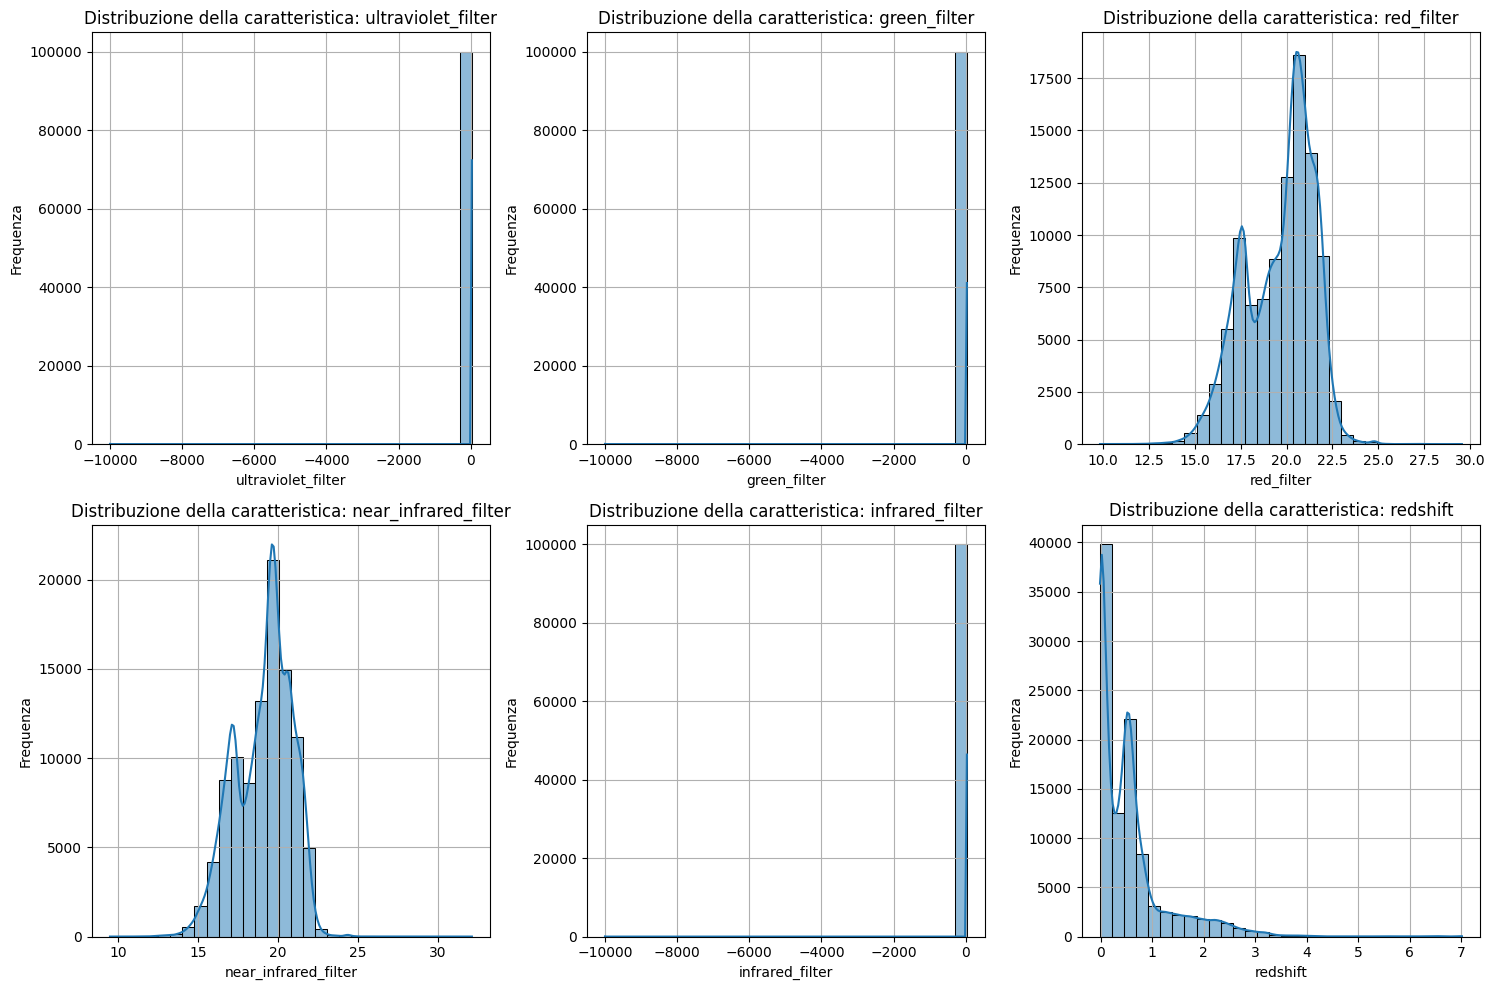

In [505]:
plot_feature_distribution(numeric_features)

Possiamo notare che per le features "ultraviolet_filter", "green_filter", e "infrared_filter" ci sono valori anomali -9999.
Procediamo a rimuovere questi valori dal nostro dataframe, in quanto potrebbero essere stati inseriti come placeholder di dati mancanti.


In [506]:
# rimozione righe outliers
df = df[(df[['ultraviolet_filter', 'green_filter', 'infrared_filter']] != -9999).all(axis=1)]


Facciamo il plot dei box diagram e degli istogrammi dopo aver rimosso i valori anomali.

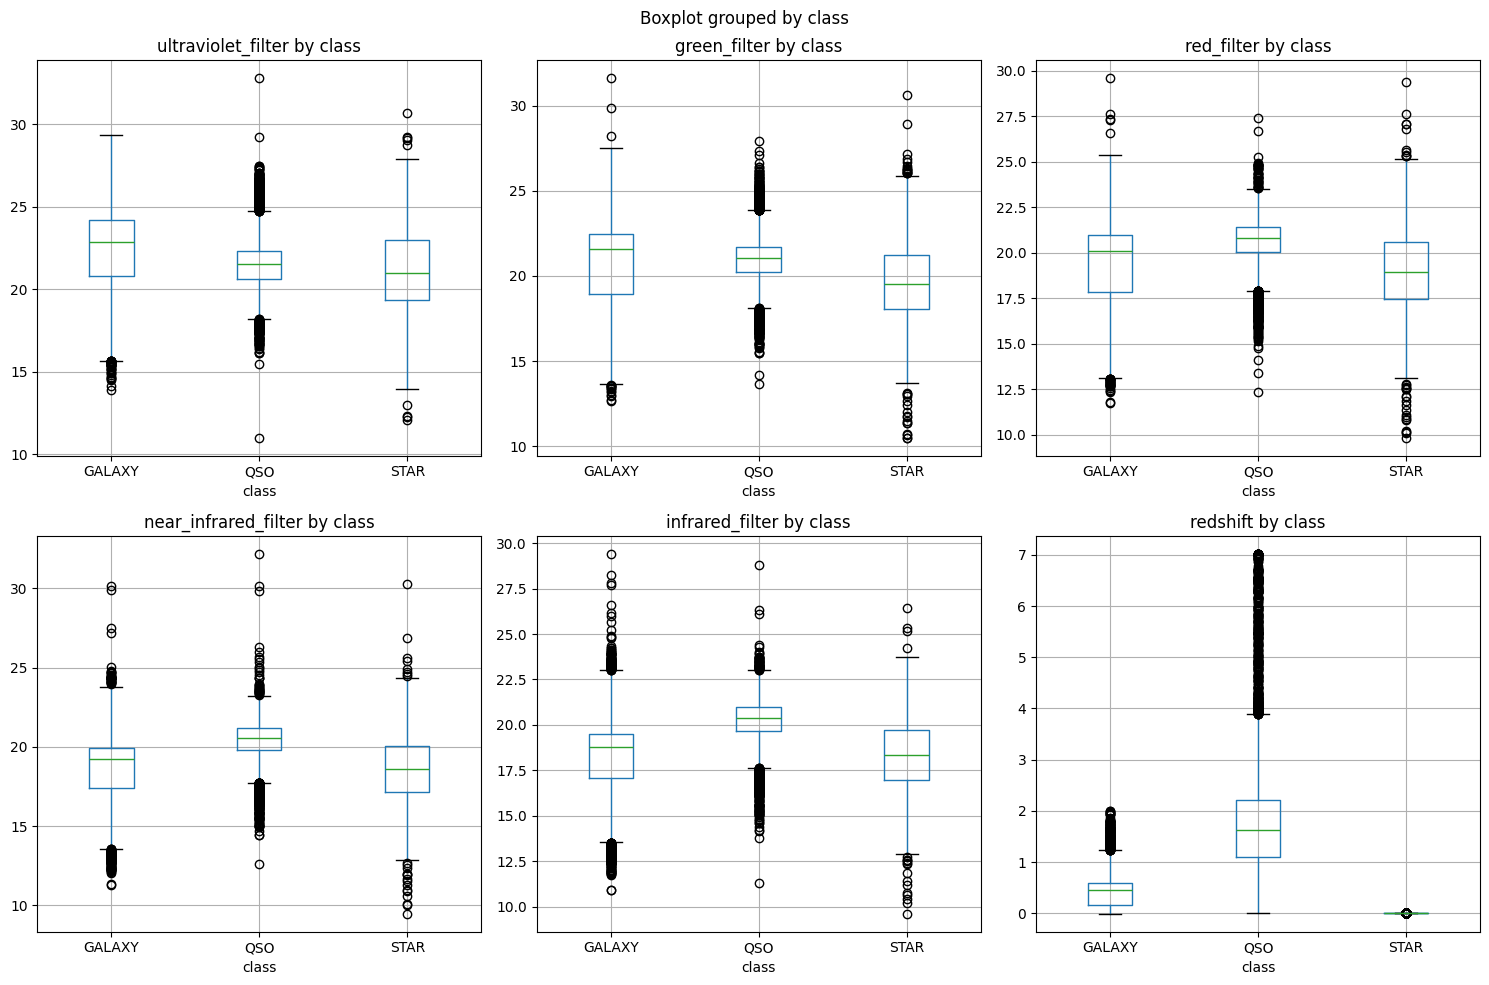

In [507]:
plot_box_diagram(numeric_features)

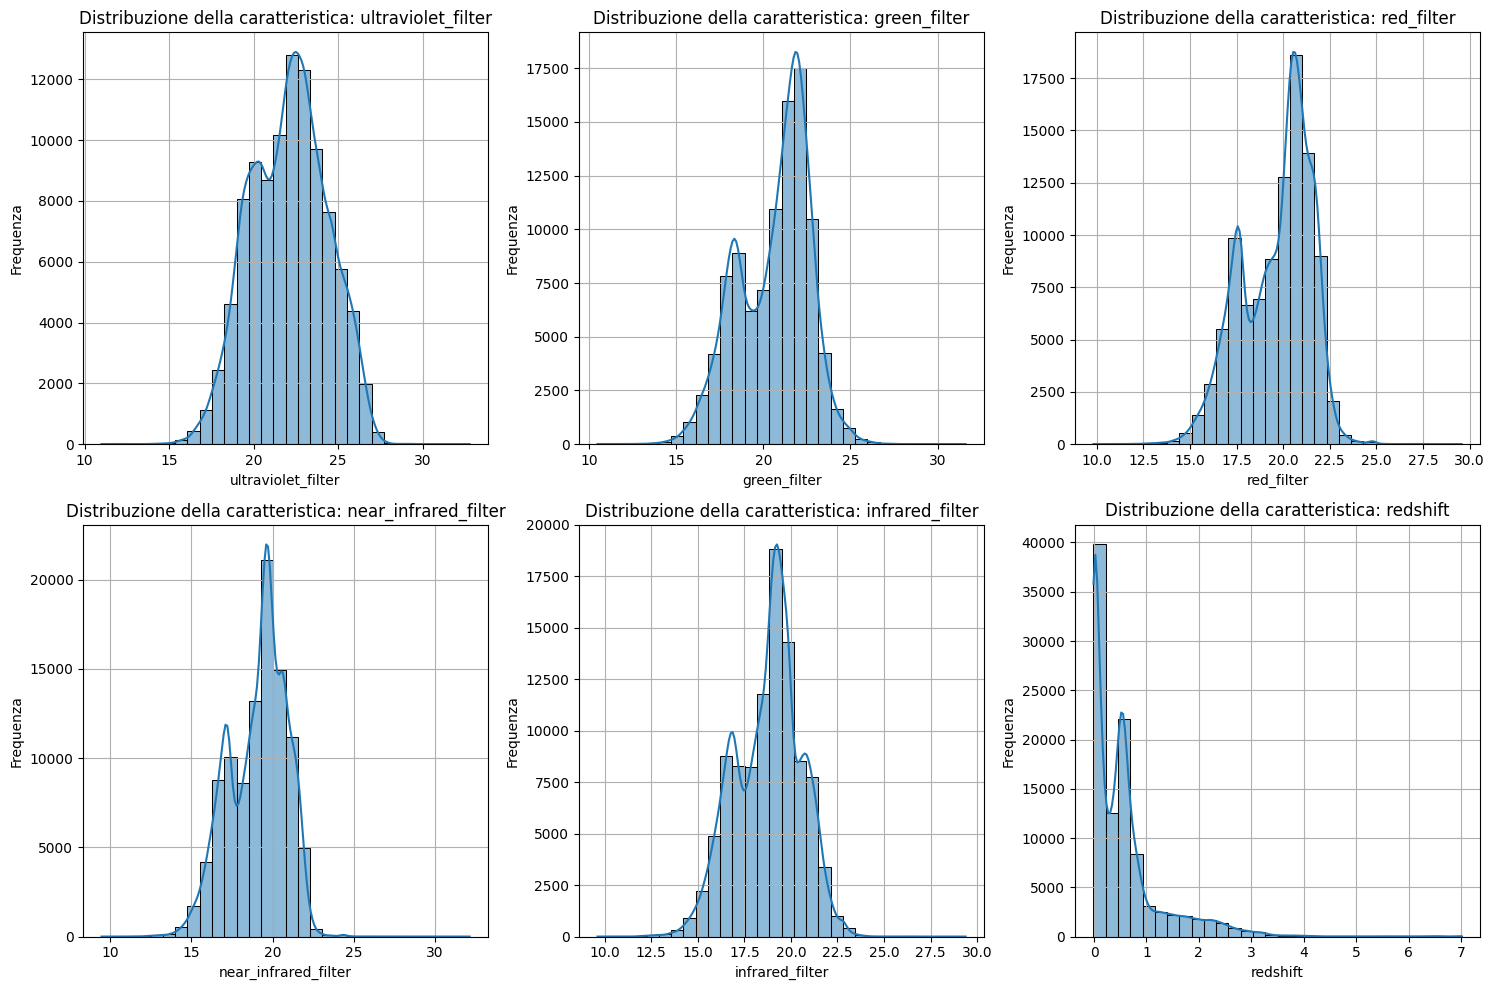

In [508]:
plot_feature_distribution(numeric_features)

Ricalcoliamo le statistiche descrittive del dataframe aggiornato senza valori anomali.

In [509]:
df.describe()

,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,camera_column,redshift,modified_julian_date
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,3.511625,0.576667,55588.653687
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1.586913,0.730709,1808.492217
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,1.000000,-0.009971,51608.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,2.000000,0.054522,54234.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4.000000,0.424176,55869.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5.000000,0.704172,56777.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,6.000000,7.011245,58932.000000


### Osservazioni dei grafici

Possiamo osservare che la feature **redshift** è probabilmente quella più discriminante tra le tre classi, in quanto:
- Stelle hanno un valore prossimo a 0
- Galassie hanno un valore compreso tra 0 e 1
- Quasar hanno un valore superiore a 1 (fino a 7 per quelli molto lontani)

### Feature Engineering

Utilizzando le magnitudini di u, g, r, i, z, posso creare i [color indices](https://en.wikipedia.org/wiki/Color_index):

- **u-g**: differenza di magnitudine tra le bande u e g
- **g-r**: differenza di magnitudine tra le bande g e r
- **r-i**: differenza di magnitudine tra le bande r e i
- **i-z**: differenza di magnitudine tra le bande i e z

Questi **indici di colore** sono molto utilizzati in astronomia e  forniscono informazioni preziose sulla temperatura e sulla composizione degli oggetti celesti.

In [510]:
df['color_u_g'] = df['ultraviolet_filter'] - df['green_filter']
df['color_g_r'] = df['green_filter'] - df['red_filter']
df['color_r_i'] = df['red_filter'] - df['near_infrared_filter']
df['color_i_z'] = df['near_infrared_filter'] - df['infrared_filter']

In [511]:
df.head()

,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,camera_column,class,redshift,modified_julian_date,color_u_g,color_g_r,color_r_i,color_i_z
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,56354,1.60352,1.88029,1.22928,0.37202
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,58158,1.94571,0.24744,1.41632,-0.44615
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,55592,2.59918,2.05413,1.26119,0.40030
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,58039,-1.63974,2.16494,1.10708,1.25444
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,56187,1.85690,1.08281,0.52036,0.43250


Per capire meglio come sono legate tra di loro le feature, visualizziamo la **matrice di correlazione**.

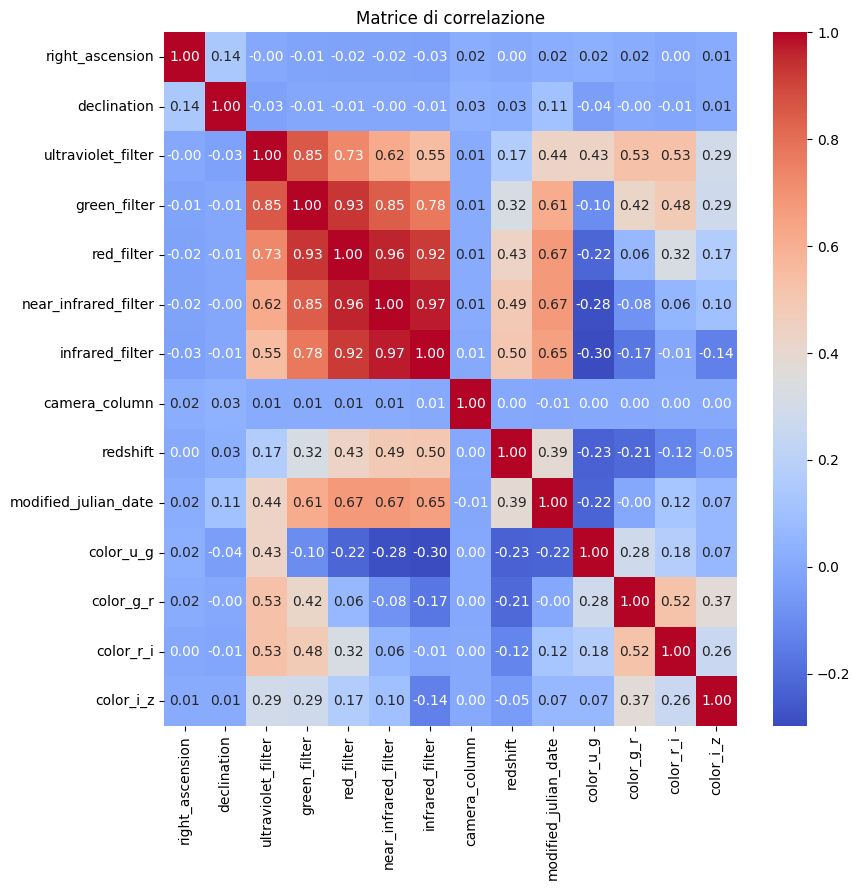

In [521]:
# Matrice di correlazione 
plt.figure(figsize=(9, 9))
# tolgo il target 'class'
features_order = [
    "right_ascension", "declination", "ultraviolet_filter", "green_filter", "red_filter", "near_infrared_filter", "infrared_filter", "camera_column", "redshift", "modified_julian_date", "color_u_g", "color_g_r", "color_r_i", "color_i_z"
]
correlation_matrix = df[features_order].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')


plt.title('Matrice di correlazione')
plt.tight_layout()
plt.show()


Dalla matrice di correlazione osserviamo che le magnitudini nelle bande ottiche **(ultraviolet_filter, green_filter, red_filter, infrared_filter, near_infrared_filter)** sono fortemente correlate tra loro, il che è atteso in quanto rappresentano misurazioni della stessa sorgente in diverse lunghezze d'onda. 

Le features aggiunte per i **color index** mostrano correlazioni moderate con i filtri ottici, il che suggerisce che le informazioni spettrali contenute in queste bande sono utili per la classificazione degli oggetti celesti.

Per quanto riguarda la modified_julian_date, sembra essere correlata positivamente con le magnitudini nelle bande ottiche, probabilmente dovuto a variazioni strumentali nel tempo.

## 3. Preparazione dei dati per il modello

A questo punto, i dati sono pronti per essere utilizzati nel modello di classificazione. Possiamo procedere con la separazione delle feature e della variabile target.


In [522]:
X = df.drop(columns=["class"])
y = df["class"]

In [ ]:
label_encoder = LabelEncoder()